<a href="https://colab.research.google.com/github/alecbidaran/Deep-learning/blob/main/Copy_of_SSIMA_2019_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SSIMA 2019 Keras + Tensorflow course

Welcome!

In the next 3h, you will:
- train a neural network in Keras for CT segmentation
- learn about common medical formats and data preprocessing to speed up training
- learn about model selection and hyperparameters
- monitor training using TensorBoard
- visualize training results


How to use:
- read the text before the code
- Ctrl+Enter to execute the next section

---


**Requirements:**
- Google account
 - Google Drive with around 1GB free
- Google Chrome
 - not my favourite, but TensorBoard won't load on specific Firefox versions
 - also, Ctrl+Enter might not work on Firefox




 .



#### Preliminary setup:

We need to train on a GPU and import some data to train on.

## 1. Colab setup

 - File > Save a copy in Drive > Open in new tab


 - Runtime > Change runtime type > GPU

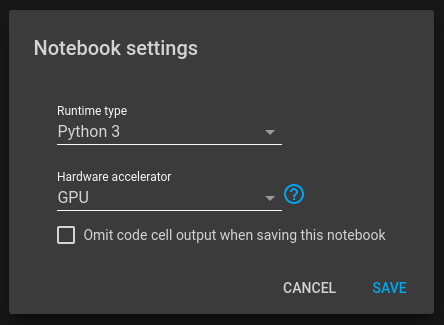


## 2. Environment setup

 **2.1.  Install Keras**

In [ ]:
#@title 2.1. Install keras
!pip install -q keras
import keras

Using TensorFlow backend.


 **2.2 Initialize TensorBoard**

 We'll discuss it later, but it needs to be initialized before training.

In [ ]:
#@title 2.2. Initialize TensorBoard
%load_ext tensorboard
import os
OUT_LOGS = 'ssima_logs'
if not os.path.exists(OUT_LOGS):
    os.makedirs(OUT_LOGS)
%tensorboard --logdir {OUT_LOGS}

<IPython.core.display.Javascript object>

 **2.3. Check GPU**

 We need to make sure it says
```'/device:GPU:0'```.




In [ ]:
#@title 2.3. Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# 3. Data

Medical datasets are few and far between:
- privacy issues
 - most hospitals are not authorize to give it away, even anonymized (remember GDPR?)
- medical equipment producers are happy to sit on data
 - more money for *their* software deployed on *their* machines
- labeling takes time and money

Labels:
- current algorithms work best supervised (that is, on labeled data)
- image labels
 - single label per image
   - e.g., image with pneumonia
 - complex label per image
   - e.g., spinal curvature

![image labels](https://aasce19.grand-challenge.org/media/i/edc5a4ba.png)
  - semantic segmentation

![Semantic segmentation](https://www.chimaera.de/fileadmin/chimaera/bilder/MRI-Segmentation-9slices.PNG)

We are going to focus on **semantic segmentation**.  
  


## 3.1. Prepare data



We will use the [3D-IRCADb-01](https://www.ircad.fr/research/3d-ircadb-01/) dataset:
- consists of 20 CTs
- focused on liver tumors (all livers + its tumours are annotated)
- mileage may vary for additional annotations
- small (< 1GB)
- conveniently uploaded to our Google Drive

![3D-IRCADb-01](https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1_package.jpg)






### 3.1.1. Allow colab access to google drive


In [ ]:
#@markdown ### 3.1.1. Allow colab access to google drive
!pip install -U -q PyDrive
from google.colab import drive, auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### 3.1.2. Copy data from Google drive to Colab

In [ ]:
#@markdown ### 3.1.2. Copy data from Google drive to Colab
download = drive.CreateFile({'id': '1AjT7FYrzOqUuJbWrZhWITM-FIG-wTwAe'})
download.GetContentFile('3Dircadb1.zip')
! unzip 3Dircadb1.zip
# Unzip data again - zips inside zip, because reasons
!find . -name '*.zip' -exec sh -c 'unzip -d "${1%.*}" "$1"' _ {} \;

Streaming output truncated to the last 5000 lines.
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_54  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_55  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_56  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_57  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_58  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_59  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_6  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_60  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_61  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_62  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_63  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_64  
  inflating: ./3Dircadb1.5/MASKS_DICOM/MASKS_DICOM/portalvein/image_65  
 

### 3.2 Create dataset for faster training

DICOM is pretty much de facto standard for medical images
- started as a good initiative for standardized medical data storage
  - ended up as a birocratized jack-of-all-trades data dump
  - don't take out word: [RTFM](https://www.dicomstandard.org/current/)

Online DICOM viewer demo: https://demo.softneta.com/

Main competitor: Nifti. Easier to work with, one file per volume.

More information about medical standards [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3948928/)

Unfortunately, our dataset uses the DICOM standard. We'll read it using *pydicom* and *dicom_numpy*.

In order to speed up training, we'll create a HDF5 dataset with [*h5py*](https://www.h5py.org/) from the volumes:
- binary format, faster read

#### 3.2.1 Decide which organ/region you want to detect

Decide what are you going to detect - this is what the semgnentation is aiming for.

In [ ]:
#@markdown ### 3.2.1 Decide which organ/region you want to detect
ORGAN_TO_DETECT = "liver" #@param ["skin", "liver", "bone"]

#### 3.2.2 Create dataset



In [ ]:
#@markdown ### 3.2.2. Create dataset
!pip install -q pydicom dicom_numpy h5py
import pydicom
import dicom_numpy
import h5py

#h5.close()

def extract_voxel_data(list_of_dicom_files):
    voxel_ndarray = None
    try:
        datasets = [pydicom.read_file(f, force=True) for f in list_of_dicom_files]
        voxel_ndarray, ijk_to_xyz = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray, ijk_to_xyz

train_folders = []
valid_folders = []

TRAIN_IDS = list(range(1,18))
VALID_IDS = list(range(18,21))

for tid in TRAIN_IDS:
  train_folders.append('/content/3Dircadb1.{}'.format(tid))

for vid in VALID_IDS:
  valid_folders.append('/content/3Dircadb1.{}'.format(vid))


DATASET_NAME = '/content/dataset.h5'

if not os.path.exists(os.path.dirname(DATASET_NAME)):
    os.makedirs(os.path.dirname(DATASET_NAME))


if True:# not os.path.exists(DATASET_NAME):
    with h5py.File(DATASET_NAME, 'w') as out_h5:
        train_array = []
        valid_array = []

        grp=out_h5.create_group('train_volumes')

        grp2=out_h5.create_group('train_labels')

        grp3=out_h5.create_group('valid_volumes')

        grp4=out_h5.create_group('valid_labels')

        idxx_h5_current = 0


        for idxx, id in enumerate(train_folders):
            print("train:{}/{}".format(idxx+1, len(train_folders)))
            ct_folder = os.path.join(id, 'PATIENT_DICOM', 'PATIENT_DICOM')
            label_folder = os.path.join(id, 'MASKS_DICOM', 'MASKS_DICOM', ORGAN_TO_DETECT)

            current_dicom_file_list_data = [os.path.join(ct_folder, x) for x in os.listdir(ct_folder)]
            current_dicom_file_list_label = [os.path.join(label_folder, x) for x in os.listdir(label_folder)]

            ct, _ = extract_voxel_data(current_dicom_file_list_data)

            width, height, num_slices = ct.shape
            print(ct.shape)

            label, _ = extract_voxel_data(current_dicom_file_list_label)

            grp.create_dataset(str(idxx_h5_current),data=ct)
            grp2.create_dataset(str(idxx_h5_current),data=label>0)
            idxx_h5_current +=1

        idxx_h5_current = 0


        for idxx, id in enumerate(valid_folders):
            print("valid:{}/{}".format(idxx+1, len(valid_folders)))
            ct_folder = os.path.join(id, 'PATIENT_DICOM', 'PATIENT_DICOM')
            label_folder = os.path.join(id, 'MASKS_DICOM', 'MASKS_DICOM', ORGAN_TO_DETECT)

            current_dicom_file_list_data = [os.path.join(ct_folder, x) for x in os.listdir(ct_folder)]
            current_dicom_file_list_label = [os.path.join(label_folder, x) for x in os.listdir(label_folder)]

            ct, _ = extract_voxel_data(current_dicom_file_list_data)

            width, height, num_slices = ct.shape
            print(ct.shape)

            label, _ = extract_voxel_data(current_dicom_file_list_label)

            grp3.create_dataset(str(idxx_h5_current),data=ct)
            grp4.create_dataset(str(idxx_h5_current),data=label>0)
            idxx_h5_current +=1



h5 = h5py.File(DATASET_NAME, 'r')

train_files = []
valid_files = []

for idx_t in range(len(h5['train_volumes'])):
    _,_,shape3 = h5['train_volumes/{}'.format(idx_t)].shape
    for idx_t_2 in range(shape3):
        train_files.append((idx_t, idx_t_2))

for idx_t in range(len(h5['valid_volumes'])):
    _,_,shape3 = h5['valid_volumes/{}'.format(idx_t)].shape
    for idx_t_2 in range(shape3):
        valid_files.append((idx_t, idx_t_2))


print('Training on {} samples'.format(len(train_files)))
print('Validating on {} samples'.format(len(valid_files)))


     |████████████████████████████████| 7.1MB 6.9MB/s 
train:1/17
(512, 512, 129)
train:2/17
(512, 512, 172)
train:3/17
(512, 512, 200)
train:4/17
(512, 512, 91)
train:5/17
(512, 512, 139)
train:6/17
(512, 512, 135)
train:7/17
(512, 512, 151)
train:8/17
(512, 512, 124)
train:9/17
(512, 512, 111)
train:10/17
(512, 512, 122)
train:11/17
(512, 512, 132)
train:12/17
(512, 512, 260)
train:13/17
(512, 512, 122)
train:14/17
(512, 512, 113)
train:15/17
(512, 512, 125)
train:16/17
(512, 512, 155)
train:17/17
(512, 512, 119)
valid:1/3
(512, 512, 74)
valid:2/3
(512, 512, 124)
valid:3/3
(512, 512, 225)
Training on 2400 samples
Validating on 423 samples


## 3.4. Prepare training environment

Setting the random seeds helps obtaining reproducible results.
- there's a black box random inside NVIDIA's cuDNN - don't expect *identical* results

In [ ]:
#@markdown ### 3.4. Prepare training environment
# setting for reproducible results
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
#tf.random.set_seed(1234)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


## 3.5. Define model and loss function

**3.5.1. Model**

The **model** (aka the neural network) is the second most important aspect of the whole training. It is basically the 'brains' of your alogirthm.
- the first is data, just in case it's not clear by now
- a straightforward idea would be to slap the largest one you could fit on a GPU
 - big brains == more inteligence, but only when it comes to humans (so far)
 - this is not a good strategy, especially if you have very limited data to begin with
   - imagine Einstein watching Honey Boo Boo on repeat
 - even you have *a lot* of data, what if the thing you want to derive from it is small (say, pancreas segmentation?)

**The best for (general) image segmentation:**
Hybrid task cascade
- basically a set of cascaded networks that produce masks

Faster R-CNN >> Mask R-CNN >> HTC


Faster R-CNN
![image.png](https://jhui.github.io/assets/rcnn/st8.png)
![alt text](https://image.slidesharecdn.com/pr12fasterrcnn170528-170802143120/95/faster-rcnn-pr012-36-638.jpg?cb=1504447138)
![alt text](https://static.leiphone.com/uploads/new/images/20190223/5c70f2e745704.png?imageView2/2/w/740)

For medical image segmentation we are going to focus on **u-nets**:
![alt text](http://cfile9.uf.tistory.com/image/2503513A570E382017CEDC)

The model we are going to use today is a smaller U-Net coming from Alina's research.

TODO: insert image without aerial stuff.


**3.5.2. Loss function**

Training a neural network is an optimization problem - we aim to minimize/maximize an objective.

Even with a model defined, one would still need to define the *loss function*. In our case, given a prediction and ground truth image, how are going to score the result - that is, what are we going to maximize?

We are going to use the **dice loss**:

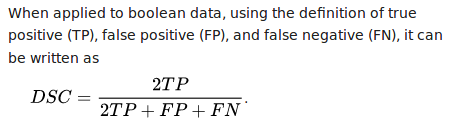


In [ ]:
#@markdown ### 3.5. Define loss and model
from keras.losses import binary_crossentropy, mean_squared_error
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose
from keras.optimizers import RMSprop

# LOSS
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


#MODEL
def unet_tiny(input_shape=(512, 512, 1), init_nb=16, lr=0.0001, loss=bce_dice_loss, num_classes=1):

    inputs = Input(input_shape)

    down1 = Conv2D(init_nb, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1pool = Conv2D(init_nb, (3, 3), padding='same', strides=(2, 2))(down1)
    down1pool = BatchNormalization()(down1pool)
    down1pool = Activation('relu')(down1pool)

    down2 = Conv2D(init_nb * 2, (3, 3), padding='same')(down1pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2pool = Conv2D(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(down2)
    down2pool = BatchNormalization()(down2pool)
    down2pool = Activation('relu')(down2pool)

    down3 = Conv2D(init_nb * 4, (3, 3), padding='same')(down2pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3pool = Conv2D(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(down3)
    down3pool = BatchNormalization()(down3pool)
    down3pool = Activation('relu')(down3pool)

    # stacked dilated convolution
    dilate1 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=1)(down3pool)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=2)(dilate1)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=4)(dilate2)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=8)(dilate3)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)

    dilate_all_added = add([dilate1, dilate2, dilate3, dilate4])

    up3 = Conv2DTranspose(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(dilate_all_added)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = add([down3, up3])
    up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = Conv2DTranspose(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(up3)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = add([down2, up2])
    up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    up1 = Conv2DTranspose(init_nb, (3, 3), padding='same', strides=(2, 2))(up2)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = add([down1, up1])
    up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(lr), loss=loss, metrics=[dice_coeff])

    return model

## 3.6. Define training and validation function

Keras needs a function for fetching *training* and *validation* data
- this is called every time a new batch is needed

In [ ]:
#@markdown ### 3.6. Define training and validation generators
def train_generator():
    while True:
        for start in range(0, len(train_files), BATCH_SIZE):
            x_batch = []
            y_batch = []
            end = min(start + BATCH_SIZE, len(train_files))
            ids_train_batch = train_files[start:end]
            for id in ids_train_batch:
                img = h5['train_volumes/{}'.format(id[0])][:,:,id[1]]
                max_img = np.max(img)
                min_img = np.min(img)

                img = (img - max_img) / (max_img- min_img + np.spacing(1))

                img = np.expand_dims(img, axis=2)

                mask = h5['train_labels/{}'.format(id[0])][:,:,id[1]]

                mask = np.expand_dims(mask, axis=2)

                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch



def valid_generator():
    while True:
        for start in range(0, len(valid_files), BATCH_SIZE):
            x_batch = []
            y_batch = []
            end = min(start + BATCH_SIZE, len(valid_files))
            ids_valid_batch = valid_files[start:end]
            for id in ids_valid_batch:
                img = h5['valid_volumes/{}'.format(id[0])][:,:,id[1]]
                max_img = np.max(img)
                min_img = np.min(img)

                img = (img - max_img) / (max_img- min_img + np.spacing(1))

                img = np.expand_dims(img, axis=2)

                mask = h5['valid_labels/{}'.format(id[0])][:,:,id[1]]

                mask = np.expand_dims(mask, axis=2)

                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

Batch, what?

Ideally, we would concatenate all avaliable data in a single ~~volume~~ tensor, forward all of them through our model, compute the loss, update the weights and that's it - an *epoch*.
- that is, when all the data was forwarded through the model once
- passing the whole dataset in a single forward is not attainable in the foreseable future
  - we need to split the data into *batches*, or *mini-batches*, as they are sometimes called
  - we would like our batch to be as large as possible
  - this is limited by GPU memory - determined empirically
  - specific cases (I/O bottleneck) when large batches hurt performace
   - training from a NVMe device is ideal
  - determine maximum batch size below
  
- the number of maximum epochs is up for debate, but generally you can put a ridiculosly high number and relay on *early stopping* strategy to halt the training when no significnat improvements on the validation set have been recorded
  - see it in action below



In [ ]:
#@markdown ### 3.6.1 Define max epoch and batch size
#@markdown

MAX_EPOCHS = 5  #@param {type: "number"}

BATCH_SIZE = "8" #@param ["4", "8", "16"] {allow-input: true}
#@markdown ---

BATCH_SIZE = int(float(BATCH_SIZE))
MAX_EPOCHS = int(float(MAX_EPOCHS))

Another set of important numbers to set before starting a training are *hyperparameters*.
- for absolute *best* results, you would do a grid search, but it's generally not worth the time/resources
  - usually, a couple of %
- we'll be discussing **learning rate** only
  - if the learning rate is too high, the loss will oscillate and nothing useful will be learnt
    - it's like we're trying to reach a peak with a modified offroad Ferrari - probably going to miss the peak and fall a couple of times
  - if the learning rate is too low training will take forever
    - it's like we're taking an average american on an Everest trip - probably not going to make it in time
  
Of course, there are a number of choices for the thing that actually performs the optimization (the *optimizer*). Lots of math there, long story short, SGD was the engine that started the 'deep learning' revolution, it has some limitations, we're using *RMSProp*.

![optimizers](https://miro.medium.com/max/620/1*SjtKOauOXFVjWRR7iCtHiA.gif)

In [ ]:
LEARNING_RATE = 0.0001 #@param ["0.1", "0.001", "0.0001", "0.00001"] {allow-input: true}

LEARNING_RATE = float(LEARNING_RATE)

## 3.7. Train + visualize training progress

Finally, we can start training!

You can go back to the TensorBoard above [ NO CLUE HOW TO ADD LINK TO CELL :|] and watch the loss go down.

Keras has a callback mechanism - a class/set of functions that are called each time a batch or epoch has started/ended.

We are going to save the best models from time to time (the *ModelCheckpoint* callback) and stop when we have little to learn (the *ReduceLROnPlateau* callback).

In [ ]:
#!pip install -q keras==2.2.5
#from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

OUT_WEIGHTS = '/content/training_results'

if not os.path.exists(OUT_WEIGHTS):
    os.makedirs(OUT_WEIGHTS)

# remove old logs
import shutil
try:
  shutil.rmtree(OUT_LOGS)
except:
  pass

if not os.path.exists(OUT_LOGS):
    os.makedirs(OUT_LOGS)


callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-3),
             ModelCheckpoint(monitor='val_loss',
                             filepath=os.path.join(OUT_WEIGHTS, 'EPOCH_{epoch:02d}_FMtrain_{dice_coeff:.5f}_trainLoss_{loss:.5f}_FMvalid_{val_dice_coeff:.5f}_valLoss_{val_loss:.5f}.hdf5'),
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir=OUT_LOGS, update_freq=100)] # update_freq='batch'

model = unet_tiny(lr=LEARNING_RATE)


model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_files)) / float(BATCH_SIZE)),
                    epochs=MAX_EPOCHS,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(valid_files)) / float(BATCH_SIZE)))

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/5
300/300 [==============================] - 217s 725ms/step - loss: 1.1689 - dice_coeff: 0.1891 - val_loss: 1.1527 - val_dice_coeff: 0.1338
Epoch 2/5
205/300 [===================>..........] - ETA: 53s - loss: 0.9635 - dice_coeff: 0.2732

KeyboardInterrupt: ignored

## 3.8. Test

Let's check the results!

Normally, you would load the weight of a predefined model, but since we alredy have it loaded in memory, we are going to use it as is.

The results are shown below for each CT slice:

**normalized CT image --- model prediction --- ground truth**

  0%|          | 0/53 [00:00<?, ?it/s]

Predicting on 423 samples with batch_size = 8...


  4%|▍         | 2/53 [00:02<01:17,  1.51s/it]/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 30%|███       | 16/53 [00:13<00:30,  1.20it/s]

KeyboardInterrupt: ignored

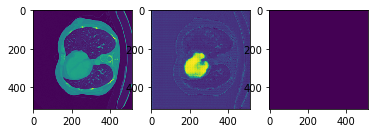

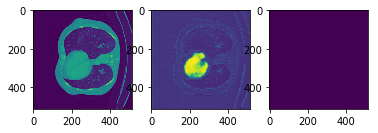

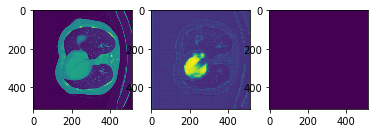

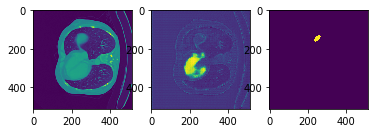

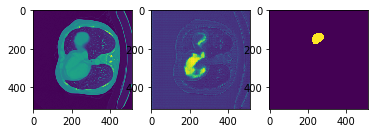

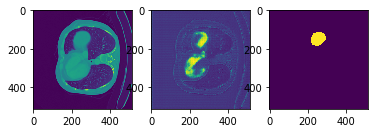

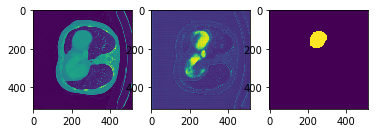

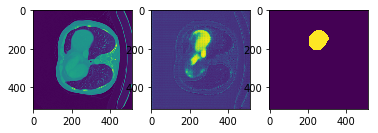

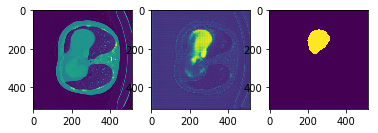

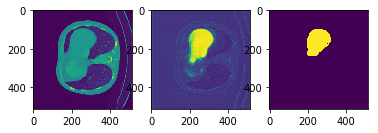

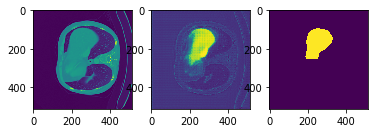

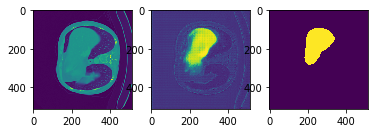

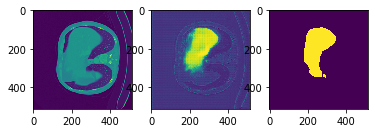

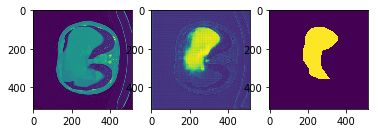

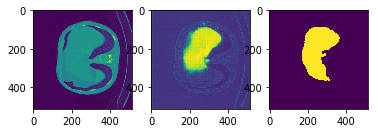

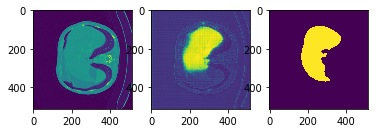

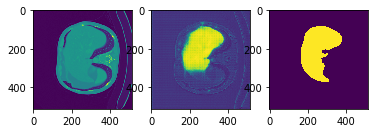

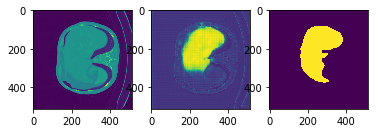

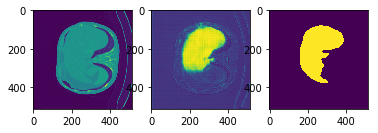

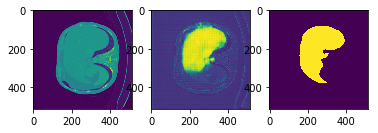

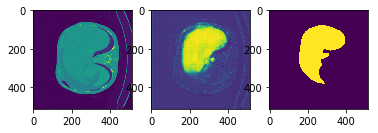

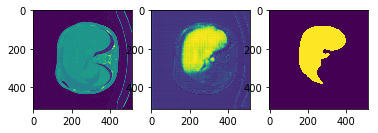

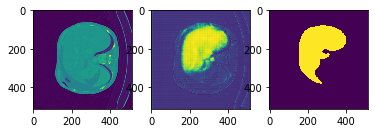

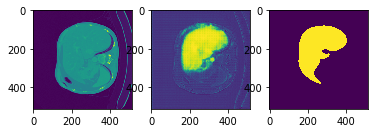

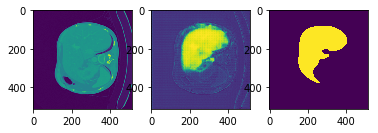

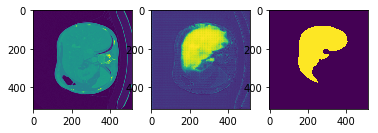

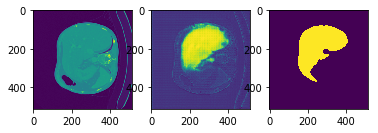

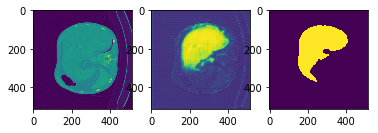

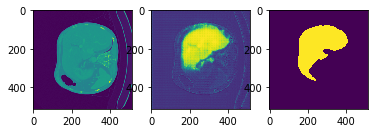

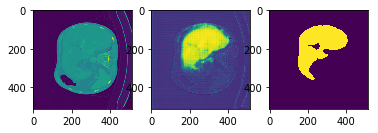

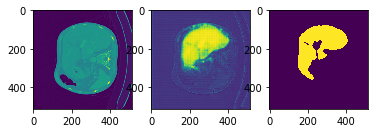

Error in callback <function flush_figures at 0x7f810f0edea0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
!pip install tqdm
from tqdm import tqdm
import cv2

%matplotlib inline

import matplotlib.pyplot as plt

OUTPUT_FOLDER = '/content/prediction_results'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# model.load_weights(filepath=WEIGHTS_PATH)

print('Predicting on {} samples with batch_size = {}...'.format(len(valid_files), BATCH_SIZE))
for start in tqdm(range(0, len(valid_files), BATCH_SIZE)):
    x_batch = []
    y_batch = []
    end = min(start + BATCH_SIZE, len(valid_files))
    ids_valid_batch = valid_files[start:end]
    for id in ids_valid_batch:
        #print('{0}/{1}'.format(TRAIN_PATH, id))
        img = h5['valid_volumes/{}'.format(id[0])][:,:,id[1]]
        max_img = np.max(img)
        min_img = np.min(img)

        img = (img - max_img) / (max_img- min_img + np.spacing(1))

        img = np.expand_dims(img, axis=2)

        mask = h5['valid_labels/{}'.format(id[0])][:,:,id[1]]

        mask = np.expand_dims(mask, axis=2)
        #mask = mask[:,:,:2]
        x_batch.append(img)
        y_batch.append(mask)
    x_batch = np.array(x_batch, np.float32)
    y_batch = np.array(y_batch, np.float32)

    preds = model.predict_on_batch(x_batch)
    #preds = np.squeeze(preds, axis=3)
    for idx_result, id in enumerate(ids_valid_batch):
        prediction = preds[idx_result,:,:,:]
        #pred0 *= 255
        #print(prediction.shape)
        img = np.squeeze(x_batch[idx_result,:,:,:])

        gt = np.squeeze(y_batch[idx_result,:,:,:])

        fig = plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(img*255)
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(prediction)*255)
        plt.subplot(1, 3, 3)
        plt.imshow(gt*255)

# 4. Final thoughts

That's it!

Thank you for attending this course.

We hope you got a general idea on how to train neural networks with Keras and general problems that might come along the way.

We believe Keras is modular enough to be used for prototyping as well as production (moslty due to Tensorflow backend).

There are other resources if you are looking for the fastest way (that is, minimum lines of code) to train something (e.g., [Fast.ai](https://course.fast.ai/)).



You can reach us at alina.marcu@stud.acs.upb.ro or dragos.costea@stud.acs.upb.ro for additional questions.